# Exercise Sheet 1 – PyTorch Basics

 * Deep Learning – Winter term 2020/21
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Due date: Nov 16, 2020 at noon


# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells.


# Introduction

In this task you will get to know the basic tools used by the machine learning community.
Later, we will build a logistic regression model with PyTorch and perform training and prediction on the MNIST dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [Pytorch Tutorial](https://pytorch.org/tutorials/)
*   [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html)


## Imports

Jupyter notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [1]:
import os
import random
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import fastprogress

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Go to Edit -> Notebook settings -> Select GPU as Hardware accelerator.

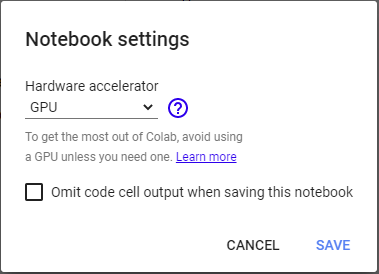

Now check the availability again.

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

Choose your device for computation. CPU or one of your CUDA devices?

In [4]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


# PyTorch tutorial

PyTorch is a library for deep learning on arbitray datasets, including irregular input data such as graphs, point clouds and manifolds. 

In this short tutorial we will explore some of its features to handle data in tensors. 
If you want to, you can look into more [detailed PyTorch tutorials](https://pytorch.org/tutorials/) online.

In [5]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.tensor(numpyarray)
# or
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [6]:
# TODO print the array
print(a)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


In [7]:
# TODO print its type
a.dtype

torch.int64

In [8]:
# TODO print its shape
a.shape

torch.Size([2, 5])

In [9]:
# TODO print its size
a.size()

torch.Size([2, 5])

In [10]:
# TODO convert the tensor back to a numpy array and print its size again
b = a.numpy()
print(b.size)

10


Let's create some new tensors.

In [11]:
# TODO create tensor (2,5) filled with ones of type int and print it
c = torch.ones([2,5], dtype=int)
print(c)

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])


In [12]:
# TODO create tensor (3,4) filled with zeros and print it
d = torch.zeros([3,4])
print(d)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [13]:
# TODO transpose a
transpose = torch.transpose(a, 0, 1)
print(a)
print(transpose)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])


Now change a value in the numpy array. Does the corresponding tensor change?

In [14]:
# TODO change value in numpy array and inspect the tensor a
numpyarray[0,0] = 10
print(a)

a[0,0] = 11
print(numpyarray)

tensor([[10,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]])
[[11  1  2  3  4]
 [ 5  6  7  8  9]]


Yes the corresponding tensor changes as well

Does it work the other way round as well?

Yes, it works the other way around as well

Now we want to make use of the different devices available, namely cpu and gpu. 

In [15]:
# TODO move a copy of 'a' it to the gpu
a_copy = a.to(device)
a_copy.is_cuda

a[0,0] = 22
print(a_copy)

tensor([[11,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]], device='cuda:0')


If you change a value in the tensor now, does the corresponding value in the tensor on the GPU change as well?

No, changing a does not change the tensor on the GPU

# MNIST Dataset
This dataset contains handwritten digits, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across later under other concepts. 

The first thing you should always do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties.

**Download** the train split of the MNIST dataset using torchvision dataset classes.

In [16]:
data_dir = pathlib.Path('data/')
mnist_train = datasets.MNIST(data_dir, download=True, train=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's check the first ten samples to see what they look like

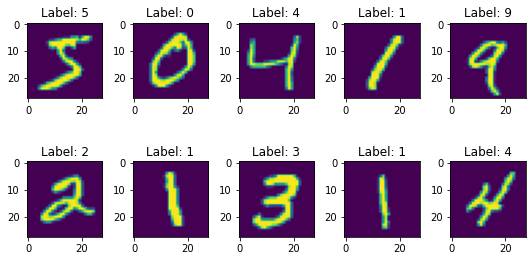

In [17]:
X_sample, y_sample = mnist_train[0]
# TODO: display the label and the image

num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    X_sample, y_sample = mnist_train[i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_sample)
    ax.set_title('Label: {}'.format(y_sample))
plt.tight_layout()
plt.show()

Look at the types of X and y.

In [18]:
# TODO: display types
print(type(X_sample))
print(type(y_sample))

<class 'PIL.Image.Image'>
<class 'int'>


How many data points are there in the dataset?

In [19]:
# TODO: print out the length of the dataset
len(mnist_train)

60000

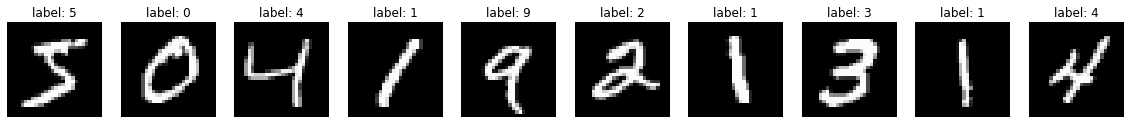

In [20]:
N = 10
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))
X, y = mnist_train.data, mnist_train.targets
for ax, image, label in zip(axes.ravel(), X, y):
  ax.set_title("label: {}".format(label))
  ax.axis('off')
  ax.imshow(image.reshape(28,28), cmap='gray') # Remember, images are 28x28

The following plots show more information about the dataset:
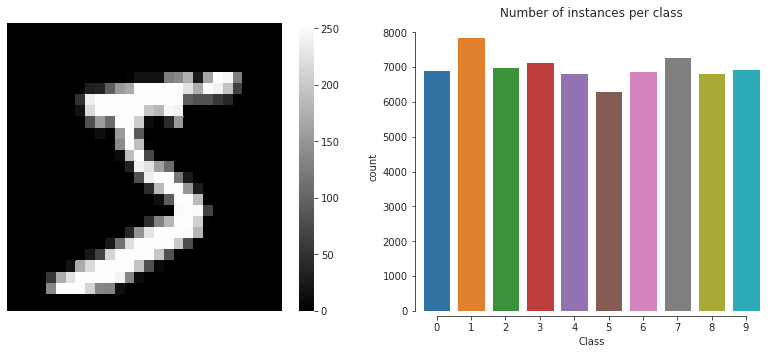


# Pre-process the data

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, pytorch (the core that is, not torchvision or torchtext) is only equipped to work on Tensor objects. So we need to **transform** _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

In [22]:
mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=transforms.ToTensor())
#mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))

## Normalization


tmp_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance. 

See https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize for more information.

We can combine multiple transformations via _transforms.Compose_.

So let's create a new dataset that we will be using for testing purposes with those transformations in-place.


In [23]:
tmp_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)

In [24]:
data = next(iter(tmp_dataloader)) 
mean = data[0].mean()
std = data[0].std()
print(mean)
print(std)

tensor(0.1307)
tensor(0.3081)


In [25]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

In [26]:
# TODO load the test set applying the transform defined above
mnist_test = datasets.MNIST(data_dir, download=True, train=False, transform=mnist_transforms)

Now let's create a dataloader for the test dataset.


In [27]:
batch_size = 256

In [28]:
# TODO create the dataloader for the test set
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True)

## Training, Validation and Test Sets

In the previous step we created a test dataset. 

But one dataset is not enough for training a model. In total, we need three datasets: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data. 

Note that you should not use the test set in any part of your training and model selection procedure. It should be only used for showing the final results.

Now we need to create the dataset and dataloader for training and validation. 
Both sets are used in the process of model fitting (visualized in the graphic below taken from the lecture slides).
While the training set needs to be quite large, the validation set can be relatively small.

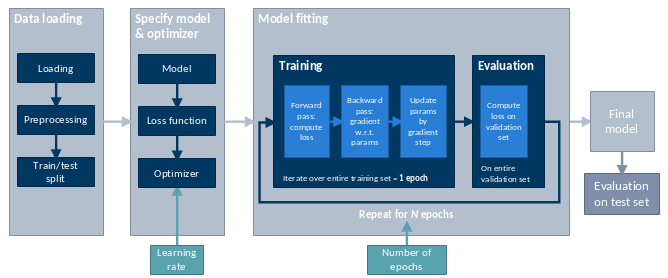

In order to split up the remaining data in training and validation, we first need to **load** the datasets.
Above, we did that already for the test set data. Now it is your turn to do it for the **training** data.

In [29]:
# TODO download the dataset for training and validation, this time with normalization transform
mnist_rest = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)

Split the dataset in two sets, one for training and one for validation. Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure reproducibility.

In [30]:
# TODO split the dataset
mnist_train, mnist_val = torch.utils.data.random_split(mnist_rest, [54000, 6000], generator=torch.Generator().manual_seed(42))
print(len(mnist_train))
len((mnist_val))


54000


6000

To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.
Use the batch size as specified above.
Make sure we get shuffled samples in batches.

In [31]:
# TODO create dataloader for training and validation
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size= batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size= batch_size, shuffle=True)

Let's get a data point now to see what we're dealing with. 

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [32]:
# TODO display an element of the train_dataloader
x, y = next(iter(train_dataloader))
print(x)
print(y)

tensor([[[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          ...,
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]],


        [[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          ...,
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]],


        [[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.424

In [33]:
# TODO display the dimensions of x and y
print(x.shape)
print(y.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


x has size (\[batchsize\], 1, 28, 28) --> 256 batches (or whatever you have defined in your data loader), 1 channel (the images are monochrome), and the dimensions of the images are 28 height/rows and 28 width/cols.

y has size (\[batchsize\]) --> 256 images (again depends on your data loader config). There's one label for each of the images in the batch.

# Stochastic Gradient Descent and Logistic Regression
Now that you know what MNIST looks like, in this task you can work with the dataset to classify handwritten digits.


## Create a model

The task is now to define a model to train on the data. In this simple example, we only need **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training image.

Before, we set some variables, like the input and output size of the linear layer, how long we want to train the model (number of epochs) and the learning rate.


In [34]:
epochs = 10
input_dim = 28 * 28
output_dim = 10
lr = 0.001

In [35]:
class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model
    inherits the torch.nn.Module which is the base class 
    for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LogisticRegression, self).__init__()
        # TODO define linear layer for the model
        self.Linear = torch.nn.Linear(input_dim, output_dim)       

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO flatten the input to a suitable size for the initial layer
        x = x.view(-1, 28*28).to(device)

        # TODO run the data through the layer  
        outputs = self.Linear(x)

        return outputs

### Instantiate the model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [36]:
# TODO instantiate the model
model = LogisticRegression(input_dim, output_dim)


Move the model to the GPU if available.

In [37]:
# TODO move model to device you specified above
if torch.cuda.is_available():
  model.to(device)

### Define a loss function

Since we're deadling with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in [0, 1] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

**Hint** Due to numerical reasons, softmax and cross entropy are combined to operate more stable. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [38]:
# TODO define loss function
loss_function = torch.nn.CrossEntropyLoss()

### Define the optimizer

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).

In [39]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Train the model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the images of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

In [40]:
# TODO fill in the missing lines
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Delete the gradients from last training iteration
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        labels = labels.to(device)
        y_pred = model(images)

        # Compute loss
        loss = loss_function(y_pred, labels)
        
        # Backward pass 1. calculate gradients based on loss function
        loss.backward()

        # Backward pass 2. update weights with optimizer
        optimizer.step()

### Make a prediction

Now that our model is trained, we can make a new prediction by inputting an unseen image of the test dataset.

Run this cell several times, does the model predict accurately?

Set the number of epochs to 10 and try again!

**TODO your answer here**

In [43]:
# get a random element of the test dataloader
i = random.randint(0, batch_size)
image, label = next(iter(test_dataloader))

# make a prediction
model.eval()
# no automatic gradient update needed in evaluation
with torch.no_grad():
    y_pred = model(image[i].to(device))

# print predicted label and given label
print(y_pred)
print("predicted label: ", y_pred.argmax())
print("given label: ", label[i])
print(y_pred.argmax == label[i])

tensor([[-1.5966, -0.9000, -0.3374, -1.3634,  2.9482,  0.9878,  0.4487,  0.6644,
         -0.2046,  1.8034]], device='cuda:0')
predicted label:  tensor(4, device='cuda:0')
given label:  tensor(4)
False


## Track loss and accuracy

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interested to see more about the training process, for instance how the training error evolves with time and how the accuracy (hopefully) increases while training the model longer.

Additionally we want to plot the confusion matrix at the end of the training procedure, to get an overview about which digits were easily predicted, and which digits were often confused for other, similar looking digits.
At the end of this notebook you can find an example plot of the confusion matrix.

For this step, we are going to refine the training process and add some important information saving for plotting.

In [44]:
def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified
        total: total number
    returns the ratio
    """
    return float(correct)/total

In [45]:
# TODO fill in the missing lines
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        labels = torch.autograd.Variable(y).cuda()
        y_pred = model(x)

        # For calculating the accuracy, save the number of correctly classified images and the total number
        _, predictions = torch.max(y_pred, dim=1)
        epoch_correct += torch.tensor(torch.sum(predictions==labels).item())
        epoch_total += len(predictions)

        # Compute loss
        loss = loss_function(y_pred, labels)

        # Backward pass      
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss)
    # Return the mean loss and the accuracy of this epoch
    tenslist = torch.FloatTensor(epoch_loss)
    mean = torch.mean(tenslist)
    return mean, accuracy(epoch_correct, epoch_total)

In [46]:
# TODO fill in the missing lines
def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            labels = torch.autograd.Variable(y).cuda()
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly classified images and the total number
            _, predictions = torch.max(y_pred, dim=1)
            epoch_correct += torch.tensor(torch.sum(predictions==labels).item())
            epoch_total += len(predictions)

            # Fill values into confusion matrix
            for i in range(len(predictions)):
              confusion_matrix[predictions[i]][labels[i]] += 1

            # Compute loss
            loss = loss_function(y_pred, labels)

            # For plotting the train loss, save it
            epoch_loss.append(loss)

    # Return the mean loss, the accuracy and the confusion matrix
    tenslist = torch.FloatTensor(epoch_loss)
    mean = torch.mean(tenslist)
    return mean, accuracy(epoch_correct, epoch_total), confusion_matrix

In [47]:
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    print("start training")
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # TODO train the model. Use the functions defined above.
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)

        # TODO compute metrics on validation set. Use functions defined above.
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, model, loss_function, device, master_bar)
        
        # Save losses and accuracies for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

In [48]:
num_epochs = 10

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

start training


### Plot the training and validation error

Create a plot using **seaborn** that contains both the losses on training set and the losses on the validation set for each epoch.

**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind for future exercise sheets.

In [49]:
# TODO write a plot function
accs = pd.DataFrame({'Train':train_accs, 'Val': val_accs})
losses = pd.DataFrame({'Train':train_losses, 'Val': val_losses}).astype("float")
test = train_losses
print(accs)
print(losses)


      Train       Val
0  0.878093  0.873333
1  0.880259  0.876500
2  0.881630  0.878000
3  0.883426  0.880000
4  0.884630  0.881500
5  0.885648  0.883833
6  0.886889  0.884000
7  0.887722  0.884000
8  0.888759  0.886000
9  0.889704  0.887500
      Train       Val
0  0.470894  0.474432
1  0.459630  0.463661
2  0.449810  0.452439
3  0.441207  0.446784
4  0.433612  0.438489
5  0.426800  0.431468
6  0.420703  0.425051
7  0.415086  0.425874
8  0.410026  0.417634
9  0.405331  0.411473


Text(0.5, 0, 'Epoch')

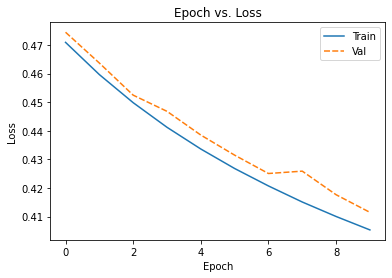

In [50]:
# TODO plot losses
loss_plot = sn.lineplot(data=losses)
loss_plot.set_title("Epoch vs. Loss")
loss_plot.set_ylabel('Loss')
loss_plot.set_xlabel('Epoch')


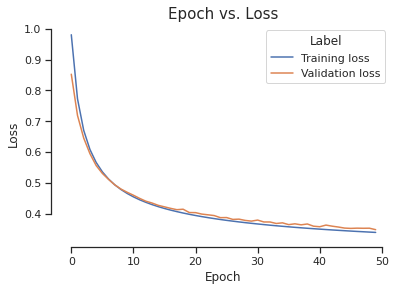

### Plot the training and validation accuracy

Now plot the accuracies on training and validation set similar to the plot before.

Text(0.5, 0, 'Epoch')

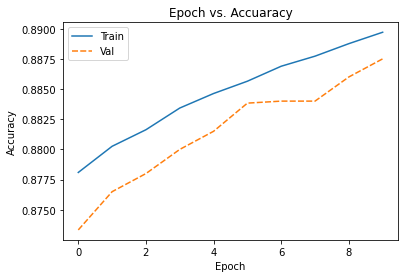

In [51]:
# TODO plot accuracies

accs_plot = sn.lineplot(data=accs)
accs_plot.set_title("Epoch vs. Accuaracy")
accs_plot.set_ylabel('Accuracy')
accs_plot.set_xlabel('Epoch')

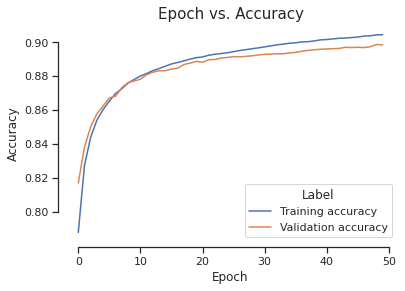

### Plot the confusion matrix

Normalize the confusion matrix and plot it using seaborn similar to the following format.

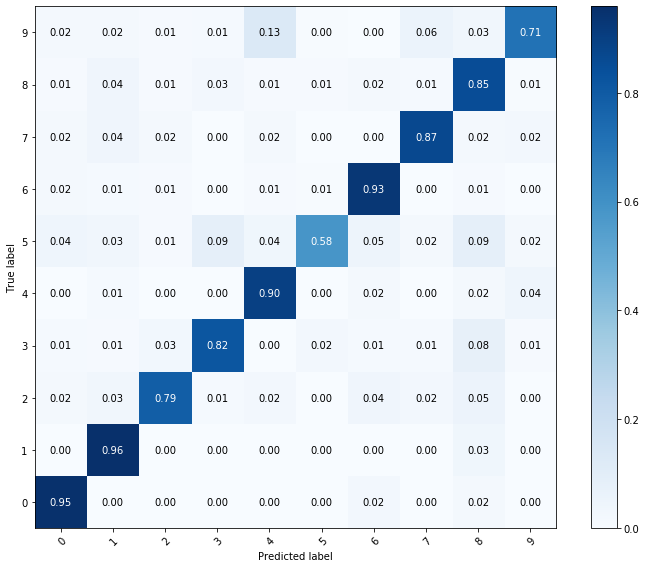

Text(33.0, 0.5, 'True Label')

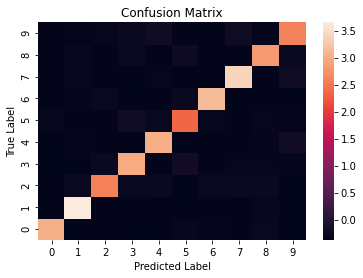

In [59]:
# TODO plot the confusion matrix
confusion_matrix = (confusion_matrix-confusion_matrix.mean())/confusion_matrix.std()
confusion_matrix = confusion_matrix.transpose(0,1)
matrix =sn.heatmap(data=confusion_matrix)
matrix.invert_yaxis()
matrix.set_title("Confusion Matrix")
matrix.set_xlabel('Predicted Label')
matrix.set_ylabel('True Label')

Which number is often confused for which number?

**TODO your answer here**
